In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.models import model_from_json

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# for the HOG features
from skimage.feature import hog
from skimage import color
from keras.models import Model
from keras.layers import Input, Concatenate

In [ ]:
# models section:
# 2 deep models (one with HOG features)
# 2 shallow models (one with HOG features)


# define the deep CNN model
def deep_model(num_class, learning_rate=0.01, regularization=1e-7):
    # Initialising the CNN
    model = Sequential()

    # 1 - Convolution
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Convolution layer
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Convolution layer
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256, kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model.add(Dense(512, kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_class, activation='softmax', kernel_regularizer=l2(regularization)))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[categorical_accuracy])

    return model


# define the deep CNN model with HOG features
def deep_hog_model(num_class, learning_rate=0.01, regularization=1e-7):
    # Input for the CNN
    cnn_input = Input(shape=(48, 48, 1))

    # CNN Layers
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(regularization))(cnn_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Flattening
    cnn_output = Flatten()(x)

    # Input for HOG features
    hog_input = Input(shape=(900,))  # Calculation of HOG Feature Dimension

    # Concatenate CNN output with HOG features
    combined = Concatenate()([cnn_output, hog_input])

    # Fully connected layers
    x = Dense(256, kernel_regularizer=l2(regularization))(combined)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    x = Dense(512, kernel_regularizer=l2(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    final_output = Dense(num_class, activation='softmax', kernel_regularizer=l2(regularization))(x)

    model = Model(inputs=[cnn_input, hog_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[categorical_accuracy])

    return model



# define the shallow CNN model
def shallow_model(num_class, learning_rate=0.001, regularization=1e-6):
    # Initialising the CNN
    model = Sequential()

    # 1 - Convolution
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(512, kernel_regularizer=l2(regularization)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_class, activation='softmax', kernel_regularizer=l2(regularization)))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[categorical_accuracy])

    return model


# define the shallow CNN model with HOG features
def shallow_hog_model(num_class, learning_rate=0.001, regularization=1e-6):
    # Input for the CNN
    cnn_input = Input(shape=(48, 48, 1))

    # CNN Layers
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(regularization))(cnn_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Flattening
    cnn_output = Flatten()(x)

    # Input for HOG features
    hog_input = Input(shape=(900,))  # Calculation of HOG Feature Dimension

    # Concatenate CNN output with HOG features
    combined = Concatenate()([cnn_output, hog_input])

    # Fully connected layer
    x = Dense(512, kernel_regularizer=l2(regularization))(combined)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    final_output = Dense(num_class, activation='softmax', kernel_regularizer=l2(regularization))(x)

    model = Model(inputs=[cnn_input, hog_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[categorical_accuracy])

    return model

balance_class(Y) = {0: 4953, 1: 547, 2: 5121, 3: 8989, 4: 6077, 5: 4002, 6: 6198}

start deep_model train
Epoch 1/35
225/225 - 31s - 137ms/step - categorical_accuracy: 0.2549 - loss: 1.8948 - val_categorical_accuracy: 0.2739 - val_loss: 1.7661
Epoch 2/35
225/225 - 13s - 56ms/step - categorical_accuracy: 0.3910 - loss: 1.5713 - val_categorical_accuracy: 0.3580 - val_loss: 1.6595
Epoch 3/35
225/225 - 20s - 88ms/step - categorical_accuracy: 0.4813 - loss: 1.3598 - val_categorical_accuracy: 0.4012 - val_loss: 1.5608
Epoch 4/35
225/225 - 20s - 90ms/step - categorical_accuracy: 0.5295 - loss: 1.2449 - val_categorical_accuracy: 0.4884 - val_loss: 1.3432
Epoch 5/35
225/225 - 12s - 55ms/step - categorical_accuracy: 0.5571 - loss: 1.1754 - val_categorical_accuracy: 0.5210 - val_loss: 1.2590
Epoch 6/35
225/225 - 12s - 55ms/step - categorical_accuracy: 0.5862 - loss: 1.1110 - val_categorical_accuracy: 0.5038 - val_loss: 1.2680
Epoch 7/35
225/225 - 12s - 55ms/step - categorical_accuracy: 0.6019 - l

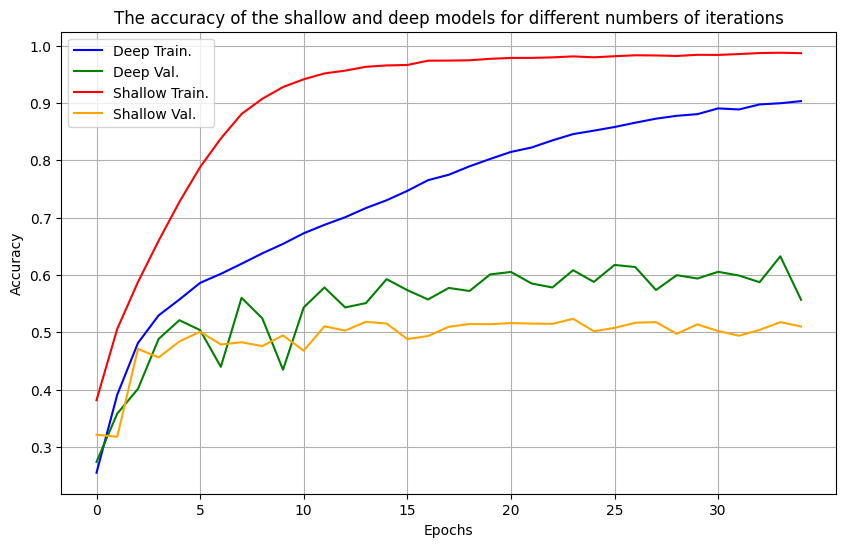

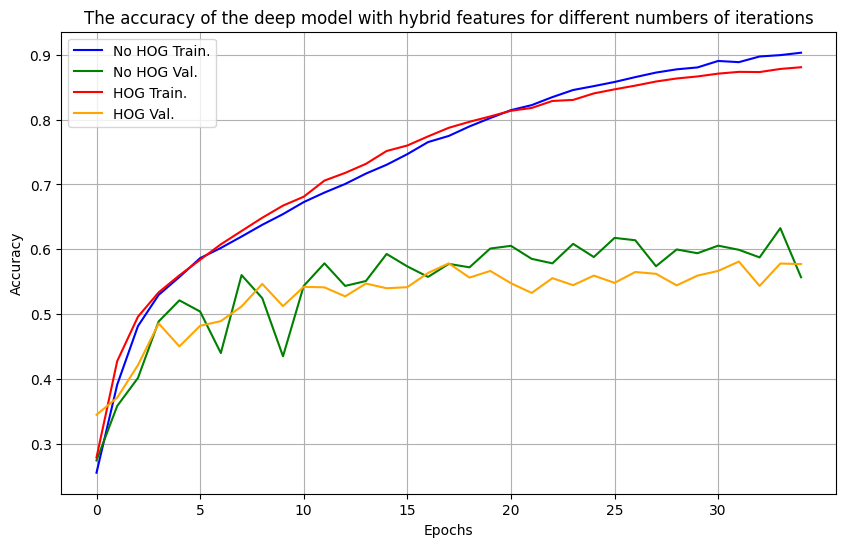

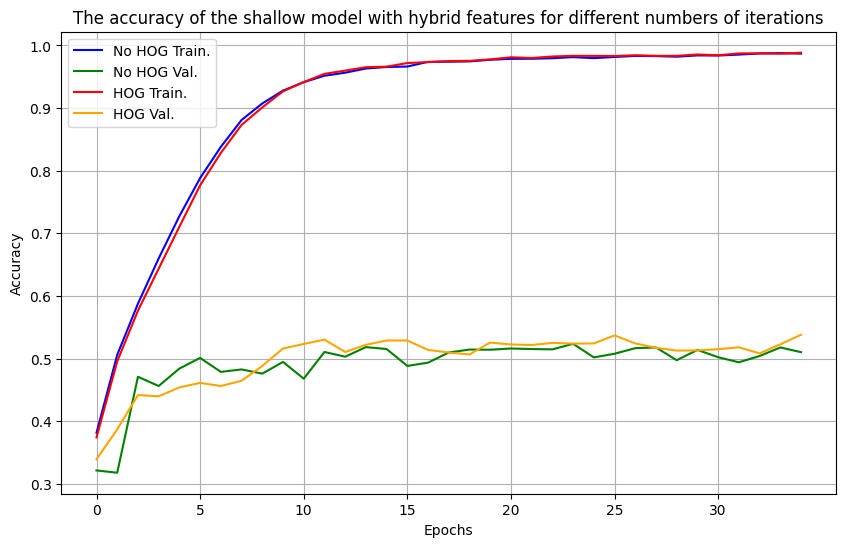

Save models to disk
start to run test on deep, shallow, deep_hog and shallw_hog models:

deep model test:

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


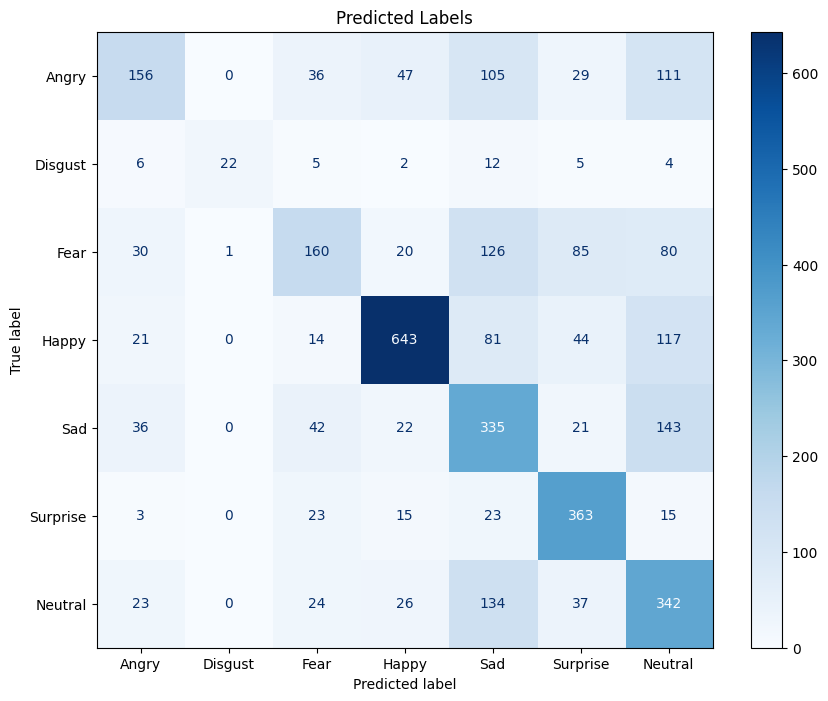

 Accuracy on Test set :  0.5631095012538312

Accuracy per label:
Accuracy for label 'Angry': 32.23%
Accuracy for label 'Disgust': 39.29%
Accuracy for label 'Fear': 31.87%
Accuracy for label 'Happy': 69.89%
Accuracy for label 'Sad': 55.93%
Accuracy for label 'Surprise': 82.13%
Accuracy for label 'Neutral': 58.36%

shallow_model test:

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


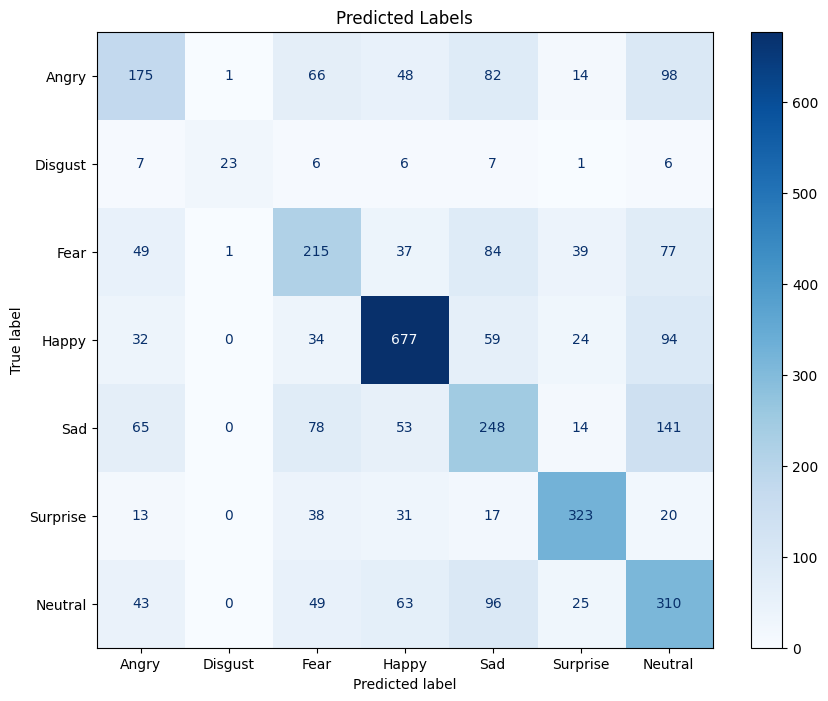

 Accuracy on Test set :  0.5491780440234049

Accuracy per label:
Accuracy for label 'Angry': 36.16%
Accuracy for label 'Disgust': 41.07%
Accuracy for label 'Fear': 42.83%
Accuracy for label 'Happy': 73.59%
Accuracy for label 'Sad': 41.40%
Accuracy for label 'Surprise': 73.08%
Accuracy for label 'Neutral': 52.90%

deep_hog model test:

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


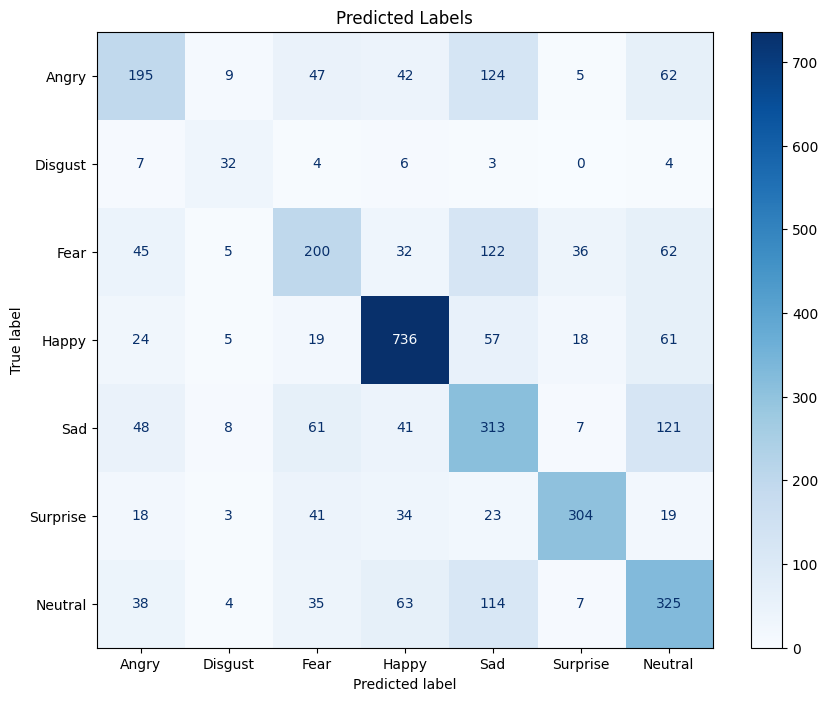

 Accuracy on Test set :  0.5865143494009474

Accuracy per label:
Accuracy for label 'Angry': 40.29%
Accuracy for label 'Disgust': 57.14%
Accuracy for label 'Fear': 39.84%
Accuracy for label 'Happy': 80.00%
Accuracy for label 'Sad': 52.25%
Accuracy for label 'Surprise': 68.78%
Accuracy for label 'Neutral': 55.46%

shallow_hog model test:

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


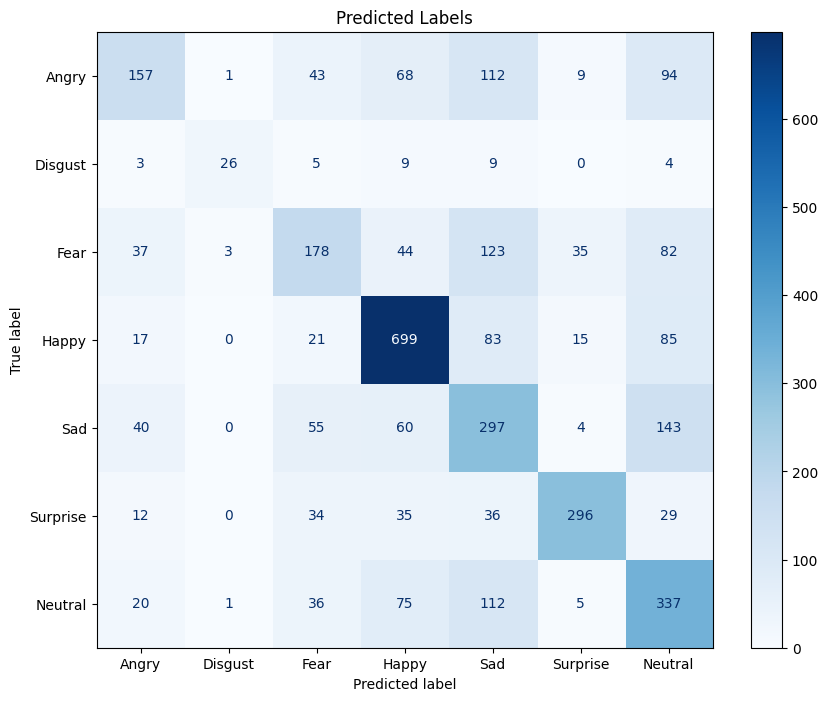

 Accuracy on Test set :  0.5544719977709669

Accuracy per label:
Accuracy for label 'Angry': 32.44%
Accuracy for label 'Disgust': 46.43%
Accuracy for label 'Fear': 35.46%
Accuracy for label 'Happy': 75.98%
Accuracy for label 'Sad': 49.58%
Accuracy for label 'Surprise': 66.97%
Accuracy for label 'Neutral': 57.51%


In [ ]:
# load data
def get_data(filename):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y


# display the number of training data point available for each label
def balance_class(Y):
    num_class = set(Y)
    count_class = {}
    for i in range(len(num_class)):
        count_class[i] = sum([1 for y in Y if y == i])
    return count_class


# Table 3 in the paper
def accuracy_per_label(new_X, y_test2, num_class):
  # Initialize counts
  correct_counts = np.zeros(num_class)
  total_counts = np.zeros(num_class)

  # Count correct predictions and total occurrences
  for pred, true in zip(new_X, y_test2):
      if pred == true:
          correct_counts[true] += 1
      total_counts[true] += 1

  # Calculate accuracy for each label
  label_accuracies = correct_counts / total_counts

  # Define label names
  label_names = [
      "Angry",
      "Disgust",
      "Fear",
      "Happy",
      "Sad",
      "Surprise",
      "Neutral"
  ]

  # Print accuracy for each label
  for label in range(num_class):
      accuracy = label_accuracies[label] if total_counts[label] > 0 else 0
      print(f"Accuracy for label '{label_names[label]}': {accuracy * 100:.2f}%")


# Figures 3,4 in the paper
def plot_accuracy(deep_history, shallow_history, lables, title):
    # Extracting accuracy values from the history

    deep_train_accuracy = deep_history.history['categorical_accuracy']
    deep_val_accuracy = deep_history.history['val_categorical_accuracy']
    shallow_train_accuracy = shallow_history.history['categorical_accuracy']
    shallow_val_accuracy = shallow_history.history['val_categorical_accuracy']

    epochs = range(len(deep_train_accuracy))

    # Plotting the accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, deep_train_accuracy, color='blue', label=lables[0])
    plt.plot(epochs, deep_val_accuracy, color='green', label=lables[1])
    plt.plot(epochs, shallow_train_accuracy, color='red', label=lables[2])
    plt.plot(epochs, shallow_val_accuracy, color='orange', label=lables[3])

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, len(deep_train_accuracy), 5))  # Set x-ticks every 5 epochs
    plt.legend()
    plt.grid()
    plt.show()


# Figures 5,6 in the paper
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Predicted Labels')
    plt.show()


def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert to grayscale if needed (assuming images are in shape (48, 48, 1))
        image_gray = color.rgb2gray(image) if image.shape[-1] == 3 else image.reshape(48, 48)
        features = hog(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)


def run_test(model, x_test, y_test):
  # Model will predict the probability values for 7 labels for a test image
  score = model.predict(x_test)

  new_X = [ np.argmax(item) for item in score ]
  y_test2 = [ np.argmax(item) for item in y_test]

  # display confusion matrix:
  plot_confusion_matrix(y_test2, new_X, ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])

  # Calculating categorical accuracy taking label having highest probability
  accuracy = [ (x==y) for x,y in zip(new_X,y_test2) ]
  print(" Accuracy on Test set : " , np.mean(accuracy))

  print("\nAccuracy per label:")
  accuracy_per_label(new_X, y_test2, num_class)


def save_model(model, filename):
   with open(filename, "w") as json_file:
        json_file.write(model)


def load_model(filename):
  with open(filename, 'r') as json_file:
        return json_file.read()


# Main: (0=Angry, 1=Disgust,2=Fear, 3=Happy, 4=Sad, 5=Surprise, and 6=Neutral)

filename = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

X, Y = get_data(filename)
num_class = len(set(Y))

print(f"balance_class(Y) = {balance_class(Y)}")

# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

# First, split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

# Now, split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1111, random_state=0)

y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_val = (np.arange(num_class) == y_val[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)


# Extract HOG features for train, validation and test
hog_train = extract_hog_features(x_train)
hog_val = extract_hog_features(x_val)
hog_test = extract_hog_features(x_test)

# Adjust shape of HOG features
hog_train = hog_train.reshape(hog_train.shape[0], -1)  # Flatten HOG features
hog_val = hog_val.reshape(hog_val.shape[0], -1)  # Flatten HOG features
hog_test = hog_test.reshape(hog_test.shape[0], -1)  # Flatten HOG features


batch_size = 128
epochs = 35
is_model_saved = False

# If model is not saved train the CNN model otherwise just load the weights
if is_model_saved == False:
    # Train model: Note : 3259 samples is used as validation data &  28,709  as training samples

    # regular models
    deep_model = deep_model(num_class)
    shallow_model = shallow_model(num_class)

    # HOG models
    deep_hog_model = deep_hog_model(num_class)
    shallow_hog_model = shallow_hog_model(num_class)

    # Train models
    print("\nstart deep_model train")
    deep_history = deep_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    print("\nstart shallow_model train")
    shallow_history = shallow_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    print("\nstart deep_hog_model train")
    deep_hog_history = deep_hog_model.fit(
                                        [x_train, hog_train],
                                        y_train,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        verbose=2,
                                        validation_data=([x_val, hog_val], y_val)
                                        )
    print("\nstart shallow_hog_model train")
    shallow_hog_history = shallow_hog_model.fit(
                                        [x_train, hog_train],
                                        y_train,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        verbose=2,
                                        validation_data=([x_val, hog_val], y_val)
                                        )


    # accuracy plots
    plot_accuracy(deep_history, shallow_history, ["Deep Train.", "Deep Val.", "Shallow Train.", "Shallow Val."]
                  , 'The accuracy of the shallow and deep models for different numbers of iterations')
    print('\n')
    plot_accuracy(deep_history, deep_hog_history, ["No HOG Train.", "No HOG Val.", "HOG Train.", "HOG Val."],
                  "The accuracy of the deep model with hybrid features for different numbers of iterations")
    print('\n')
    plot_accuracy(shallow_history, shallow_hog_history, ["No HOG Train.", "No HOG Val.", "HOG Train.", "HOG Val."],
                  "The accuracy of the shallow model with hybrid features for different numbers of iterations")

    # save models
    save_model(deep_model.to_json(), "deep_model.json")
    save_model(shallow_model.to_json(), "shallow_model.json")
    save_model(deep_hog_model.to_json(), "deep_hog_model.json")
    save_model(shallow_hog_model.to_json(), "shallow_hog_model.json")


    # serialize weights to HDF5
    deep_model.save_weights("deep_model.weights.h5")
    shallow_model.save_weights("shallow_model.weights.h5")
    deep_hog_model.save_weights("deep_hog_model.weights.h5")
    shallow_hog_model.save_weights("shallow_hog_model.weights.h5")
    print("Save models to disk")

else:
    # Load the trained model
    print("Load model from disk")

    # Load model's json files
    deep_model_json = load_model("deep_model.json")
    shallow_model_json = load_model("shallow_model.json")
    deep_hog_model_json = load_model("deep_hog_model.json")
    shallow_hog_model_json = load_model("shallow_hog_model.json")

    deep_model = model_from_json(deep_model_json)
    shallow_model = model_from_json(shallow_model)
    deep_hog_model = model_from_json(deep_hog_model_json)
    shallow_hog_model = model_from_json(shallow_hog_model_json)

    # Load the weights from the H5 file
    deep_model.load_weights('deep_model.weights.h5')
    shallow_model.load_weights('shallow_model.weights.h5')
    deep_hog_model.load_weights('deep_hog_model.weights.h5')
    shallow_hog_model.load_weights('shallow_hog_model.weights.h5')


print("start to run test on deep, shallow, deep_hog and shallw_hog models:")
print("\ndeep model test:\n")
run_test(deep_model, x_test, y_test)
print("\nshallow_model test:\n")
run_test(shallow_model, x_test, y_test)
print("\ndeep_hog model test:\n")
run_test(deep_hog_model, [x_test, hog_test], y_test)
print("\nshallow_hog model test:\n")
run_test(shallow_hog_model, [x_test, hog_test], y_test)
